## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
"""
This algorithm calculates heart beats estimates along with the confidence of each estimate
from a dataset containing ppg and 3-axis accelerometer signals.
The evaluation of the performance is made by computing the mean absolute error (MAE)
of the 90% most confident estimates.
"""
import glob

import numpy as np
import scipy as sp
import scipy.io
import scipy.signal

import matplotlib.pyplot as plt  # look at the data


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
    # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Main function to estimate the heart rates with a confidence factor and compare them to the ground truth.

    Args:
        data_fl: (str) filepath to a troika .mat file containing the ppg and accelerometer signals.
        ref_fl: (str) filepath to a troika .mat file containing the ground truth estimates.

    Returns:
        Per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Bandpass all the signals
    ppg = BandpassFilterBPM(ppg)
    accx = BandpassFilterBPM(accx)
    accy = BandpassFilterBPM(accy)
    accz = BandpassFilterBPM(accz)
    
    # Retrieve the reference heart rates
    ref = sp.io.loadmat(ref_fl)['BPM0']
    
    # Compute pulse rate estimates and estimation confidence.
    errors = []
    confidence = []
    
    # sliding window: width 8s, shift 2s
    fs = 125  # according to the documentation, the sampling frequency is 125Hz
    win_width = 8 * fs  # The width & overlap correspond to how the reference BPM was calculated
    win_overlap = 6 * fs

    # Find dominant frequencies for the accelerometer data
    acc_sign = BandpassFilterBPM(AccelerometerMagnitude(accx, accy, accz))
    acc_spec, acc_freqs, _, _ = plt.specgram(acc_sign, NFFT=win_width, Fs=fs, noverlap=win_overlap)
    acc_dominant_freqs = acc_freqs[np.argmax(acc_spec, axis=0)] * 60  # convert to BPM

    # Define the width of a peak and the number of frequencies to consider per estimate
    epsilon = 0  # A peak as a unique frequency (epsilon=0) grants the best results
    n_best_freqs = 7  # This parameter is also defined by trial and error

    # Calculate the spectogram of the ppg signal on the previously defined windows
    ppg_spec, ppg_freqs, _, _ = plt.specgram(ppg, NFFT=win_width, Fs=fs, noverlap=win_overlap, detrend='linear')

    # Calculate the heart rate estimates
    hr_estimates = np.array([])
    for i in range(len(ppg_spec[0,])):
        hr_estimates = np.append(hr_estimates, SmoothEstimates(ppg_spec, ppg_freqs, hr_estimates, n_best_freqs))
    
    # Try to separate arm motion noise from the actual heart beat frequencies
    hr_estimates = AvoidArmMotionNoise(hr_estimates, acc_dominant_freqs, ppg_spec, ppg_freqs, n_best_freqs, epsilon)

    # Calculate error and confidence
    errors = np.absolute(hr_estimates - ref.flatten())  # we calculated our estimates in the same windows as the reference
    confidence = np.array([])
    for i, estimate in enumerate(hr_estimates):
        confidence = np.append(confidence, CalcConfidence(estimate, ppg_spec[:, i], ppg_freqs, epsilon))

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, confidence

In [2]:
def BandpassFilterBPM(signal, fs=125, lower_BPM=40, higher_BPM=240):
    """
    Bandpass filter the signal between 40 & 240 BPM by default.
    
    Args:
        signal: (array) signal to bandpass.
        fs: (int) sampling frequency of the signal, default is 125.
        lower_BPM: (int) lower frequency to bandpass the filter with in BPM, default is 40.
        higher_BPM: (int) higher frequency to bandpass the filter with in BPM, default is 240.

    Returns:
        Filtered signal in a numpy array.
    """
    b, a = sp.signal.butter(3, (lower_BPM/60, higher_BPM/60), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def AccelerometerMagnitude(accx, accy, accz):
    """
    Aggregate the accelerometer signals into a magnitude signal.
    
    Args:
        accx: (array) accelerometer signal on the x axis.
        accy: (array) accelerometer signal on the y axis.
        accz: (array) accelerometer signal on the z axis.

    Returns:
        Aggregated signal in a numpy array.
    """
    return np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))


def SmoothEstimates(ppg_spec, ppg_freqs, hr_estimates, n_best_freqs):
    """
    Calculate a heart rate estimate from the spectrum of a fraction of a signal
        while taking into account previous estimates.
    
    Args:
        ppg_spec: (array) spectogram of the ppg signal the estimates are made on.
        ppg_freqs: (array) frequencies used to calculate the spectogram of the ppg signal.
        hr_estimates: (array) array containing the previous heart rate estimates.
        n_best_freqs: (int) number of the best frequencies to consider for the estimate.
            The closest of those frequencies to the previous estimate is chosen.

    Returns:
        An estimate in BPM of the heart rate frequency for the given spectrum.
    """
    # retrieve the index of the current heart rate estimate
    index = len(hr_estimates)
    # if the current estimate is not the first, we take into account the previous one
    if index != 0:
        last_estimate = hr_estimates[-1]/60
        # First, we retrieve the most impactful n_best_freqs frequencies on the spectrum
        candidates = np.argsort(ppg_spec[:, index], axis=0)[-n_best_freqs:]
        # Then, the estimate is the closest of those candidates to the last estimate to avoid unrealistic sudden shifts
        estimate = ppg_freqs[candidates[np.argmin(np.absolute(ppg_freqs[candidates] - last_estimate))]] * 60
    else:
        estimate = ppg_freqs[np.argmax(ppg_spec[:,0], axis=0)] * 60
    return estimate


def AvoidArmMotionNoise(hr_estimates, acc_dominant_freqs, ppg_spec, ppg_freqs, n_best_freqs, epsilon=0):
    """
    Try to detect and reduce the potential noise of the arm motion in the calculated heart rate estimates.
    
    Args:
        hr_estimates: (array) array containing all of the heart rate estimates.
        acc_dominant_freqs: (array) array containing the dominant frequencies
            in the aggregated accelerometer signal.
        ppg_spec: (array) spectogram of the ppg signal the estimates were made on.
        ppg_freqs: (array) frequencies used to calculate the spectogram of the ppg signal.
        n_best_freqs: (int) number of the best frequencies to consider for each estimate.
            The closest of those frequencies to the previous estimate is chosen.
        epsilon: (int) corresponds to half of the width of a peak in number of BPMs
            (if epsilon=0, a peak is a unique frequency).      

    Returns:
        A potentially modified array of heart rate estimates with less noise from arm movements.
    """
    # if a hr estimate is close to an accelerometer dominant frequency, then try to find other candidates
    noisy_samples = np.where(np.absolute(hr_estimates-acc_dominant_freqs) <= epsilon )[0]

    for noisy_sample in noisy_samples:
        # if the first estimate is potentially noisy, we do not modify it as we need previous estimates
        if (noisy_sample == 0):
            continue

        # retrieve the last and current estimates
        last_estimate = hr_estimates[noisy_sample-1]/60
        current_estimate = hr_estimates[noisy_sample]/60

        # the new candidates are samples whose distance to the acc dominant frequency is more than epsilon
        candidates = np.where((np.absolute((ppg_freqs*60) - acc_dominant_freqs[noisy_sample]) > epsilon))
        
        if len(candidates[0]) != 0:
            # we are looking for the closest freq among the candidate frequencies with the highest amplitude
            best_candidates = np.argsort(ppg_spec[candidates, noisy_sample])[0][-n_best_freqs:]
            closest_candidates = best_candidates[np.argsort(np.absolute(ppg_freqs[best_candidates] - last_estimate))]

            # Here are the rules to define a good candidate:
            # 1. If the closest candidate implies a bigger or equal shift than the current shift, it is discarded
            # This is because the smooth estimates calculation already reduces the risk of noise
            # Avoiding a potential noise shouldn't lead to a less realistic evolution or even a huge shift
            if (np.absolute(ppg_freqs[closest_candidates[0]] - last_estimate) >=
                np.absolute(current_estimate - last_estimate)):
                continue

            # 2. A good candidate is at least half of the potentially noisy frequency
            # We try to find one such candidate starting from the closest to the furthest
            for i in range(n_best_freqs):
                if (2 * ppg_spec[closest_candidates[i], noisy_sample] >= acc_dominant_freqs[noisy_sample]):
                    hr_estimates[noisy_sample] = ppg_freqs[best_candidates[i]]*60
                    break

    return hr_estimates


def CalcConfidence(hr_bpm, fft, freqs, epsilon=0):
    """
    This modified SNR algorithm calculates the confidence we have in one estimated heart rate.

    Args:
        hr_bpm: (int) heart rate estimation in BPM to calculate the confidence of.
        fft: (array) spectogram of the signal the estimate was made on.
        freqs: (array) frequencies used to calculate the spectogram.
        epsilon: (int) corresponds to half of the width of a peak in number of BPMs
            (if epsilon=0, the peak is a unique frequency).

    Returns:
        numpy float for the signal to noise ratio which is our confidence value.
    """
    # BPM to Hz
    epsilon = epsilon/60
    hr_freq = hr_bpm/60

    # Find the frequencies to compare to the entire spectrum
    hr_borders = (hr_freq-epsilon, hr_freq+epsilon)
    hr_index = np.where((freqs>=hr_borders[0]) & (freqs<=hr_borders[1]))

    # Compute signal power and noise power
    signal_power = np.sum(np.abs(fft[hr_index]))
    noise_power = np.sum(np.abs(fft))

    # Compute SNR
    snr = signal_power / noise_power
    return snr

12.145290016141464

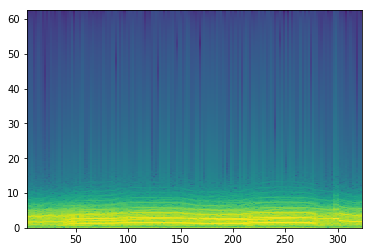

In [289]:
Evaluate()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

### Code Description

> - This algorithm is designed to estimate pulse rates using a ppg signal and 3-axis accelerometer signals.
>   - To run the algorithm to actually calculate heart rate estimates, one could delete the '# Retrieve the reference heart rates' block and replace the '# Calculate error and confidence' block in RunPulseRateAlgorithm by return hr_estimates and then run the function directly on the .mat filepath and a fake ref path.
>   - However, if the goal is to evaluate the performance of the algorithm on a new, one can simply prepare the correct input data and run Evaluate().

### Data Description

> - Here the input data (Troika dataset) was stored into a .mat file in a 'sig' variable with 6 rows. The first two rows are not used while the last 4 rows are in order a ppg signal and 3 accelerometer signals for the x, y and z axis.
The reference data was also stored into a .mat file in a 'BPM0' variable.
> - The Troika dataset also contains another ppg signal and an ECG signal, and is sampled at 125Hz. This means that there are a lot of ways to use it and the signals are fairly precise. However, it doesn't contain any information about the wearer's age, health condition or anything of the sort. This means that it's use is almost limited to pulse rate estimation. Moreover, there are only 12 sets of signals to work with. Also, I believe that because the wearers are following one of two precise sequence of activities, it is hard to generalize the algorithm to new, more natural data. So, to make the dataset more complete I think that we could add more sets with more randomly distributed activities.
> - To use this dataset, I simply bandpassed the signals between 40 & 240 BPM before calculating their spectograms because that corresponds to a realistic heart rate range.

### Algorithm Description

#### Physiology

> - We are provided with a ppg signal and 3-axis accelerometer signals. The way that a ppg sensor placed on the wrist work is by emiting a light (often green) through the skin. This light is then partly absobed by the red blood cells and the reflected light is detected and measured by a photodetector. This means that during the systole, where the blood flows from the heart to the rest of the body, more light is absorbed and we observe a trough in the signal corresponding to a heart beat. During the diastole however, where the blood returns and fills the heart, there are less blood cells in the wrist so we observe a peak in the signal. From this signal, we can try to find this period between two heart beats.

#### How the algorithm works

> - The algorithm does not imply AI in any way. It mainly works by calculating the spectogram of the ppg signal every two seconds with a width of 8 seconds. A spectogram uses Fourier transforms to compute the 'power' of the frequencies in a signal over time, from 0Hz to the Nyquist frequency. This means that every window overlaps the last by 6 seconds, and this corresponds to the way the ground truth heart rates are provided. The idea is that for each spectrum, the most important frequency in the spectrum might be the frequency of the heart rate, so we retrieve that frequency. However, this can lead to imprecise estimates and unrealistic jumps between consecutive estimates:

(0, 240)

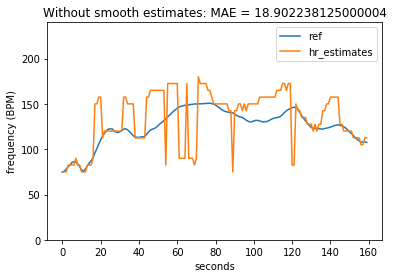

In [56]:
plt.plot(ref, label= "ref")
plt.plot(hr_estimates, label="hr_estimates")
plt.title(f"Without smooth estimates: MAE = {np.mean(errors)}")
plt.xlabel('seconds') 
plt.ylabel('frequency (BPM)') 
plt.legend()
plt.ylim(0,240)

> - Because of this, we need to compute smooth estimates, which are estimates that take into account the previous ones and do not imply unrealistic shifts. I first had the idea of only looking for frequencies around the previous estimate, but that implied arbitrarily picking a maximum shift and did not work out with every signal. So, the idea instead is to look for the n strongest frequencies (n is manually defined) and choose the closest of those frequencies. Here is the same input data with n=7, which overall worked the best.

(0, 240)

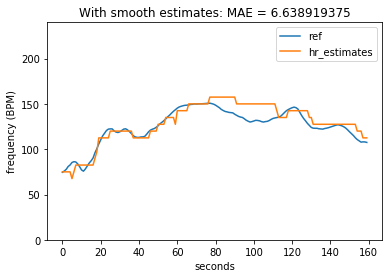

In [59]:
plt.plot(ref, label= "ref")
plt.plot(hr_estimates, label="hr_estimates")
plt.title(f"With smooth estimates: MAE = {np.mean(errors)}")
plt.xlabel('seconds') 
plt.ylabel('frequency (BPM)')
plt.legend()
plt.ylim(0,240)

#### How to avoid physoliogical noise

> - **Arm Motion :** To avoid arm motion noise, I made a function that uses the 3-axis accelerometer signal. We first have to aggregate the 3 bandpassed signals into a magnitude signal and bandpass that signal. Then, we try to find the dominant frequencies per window of the aggregated signal and when our heart rate estimates are close to the dominant frequency in a given window we try to find other frequencies for our estimate.
To define if a frequency is close to the accelerometer dominant frequency, we use the epsilon variable which represents the number of BPMs around a peak, meaning that the area around a peak is semantically attached to the peak itself as long as it is in the epslion distance. This was designed to help avoid the entirety of the noise produced by a noisy peak and just one frequency.
That being said, the epsilon that granted the best results was 0, meaning that each peak is only defined by one unique frequency.
Once we found potentially noisy estimates, we simply try to find better candidates following the philosophy of the SmoothEstimates function, but a candidate is only chosen if it fulfills two requirements:
>   - 1. If the closest candidate implies a bigger or equal shift than the current shift, it is discarded. This is because the smooth estimates calculation already reduces the risk of noise. Avoiding a potential noise shouldn't lead to a less realistic evolution or even a huge shift.
>   - 2. A good candidate is at least half of the potentially noisy frequency.
We try to find candidates amongst the n strongest frequencies, and we chose the closest to our last estimate.

> - **Arm Position :** Even while at rest, if the position of the arm changes, blood flows into or out of the wrist. If you hang your arm down, more blood will flow into it and the DC level of the signal will slowly drop. If you raise your arm up, blood will flow out of your arm and the DC level will increase.
To counter this potential noise, we use detrend='linear' in the call to plt.specgram. What this does is for each window to try and flatten the signal when it's DC level is slowly rising or decreasing.

#### Confidence computation

> - To calculate the confidence we have in any given estimate, we compute the power of the estimate frequency in the signal compared to the overall power power of the signal. This means that if the returned value is high, we can be confident that the estimate frequency is meaningful compared to if it was low. Here, I also implemented the notion of epsilon to look for the power of a given frequency and the frequencies around it in the epsilon distance as they could belong to the same peak semantically, but as previously said, epsilon=0 was ultimately chosen.

### Caveats and failure-modes of the algorithm

> - This algorithm is by no means devoid of flaws. In fact, here are those I identified:
>   - The precision is limited to find the best frequency because all of the frequencies in the spectra are separated by 0.125Hz which is 7.5 BPM ! Also, we compute the power of frequencies ranging from 0Hz to the Nyquist frequency (around 62.5 Hz, half of the sampling frequency) when we rae only really interested in frequencies ranging from 40 to 240 BPM which is around 0.6 to 4 Hz. If we do not find the exact frequency, we are at least 7.5 BPM away, which is a lot.
>   - Other noises can be found in the signals, like we can see in the (by far) worst-performing signal :

(0, 240)

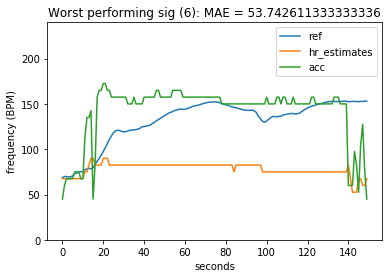

In [61]:
plt.plot(ref, label= "ref")
plt.plot(hr_estimates, label="hr_estimates")
plt.plot(ppg_freqs[acc_spec.argmax(axis=0)]*60, label="acc")
plt.title(f"Worst performing sig (6): MAE = {np.mean(errors)}")
plt.xlabel('seconds') 
plt.ylabel('frequency (BPM)')
plt.legend()
plt.legend()
plt.ylim(0,240)

> - We can clearly observe strong noises all across the signals between 70 and 90 BPM, and there is hardly a way to avoid it, especially when our smooth estimates prefer not to wander off and rather stays nearby the previous wrong estimates. It is important to note that the absolute of rfft might detect different peaks than the specgram does.

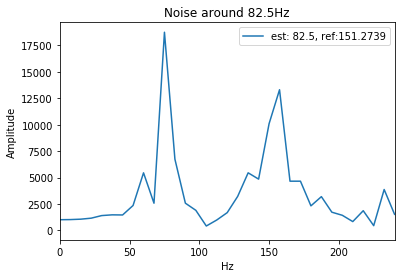

In [66]:
start = 77
signal = ppg[start*2*fs:(start+1)*2*fs + 6*fs]
signal_freqs = ppg_freqs
plt.plot(ppg_freqs*60, np.absolute(np.fft.rfft(signal)), label=f"est: {hr_estimates[start]}, ref:{ref[start][0]}")
plt.title('Noise around 82.5Hz')
plt.xlabel('Hz') 
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(0,240)
plt.legend()

> - This problem with the smooth estimates also implies that if the first estimate is severely wrong, all or a lot of the estimates might be wronged.

### Performance calculation

> - Because this algorithm does not involve any AI, the performance evaluation is simply done by taking the 90% most confident estimates we have according to the confidence metric I explained earlier, and computing the mean absolute error (MAE) of those estimates compared to the reference heart rate estimates. On the training set, this value was 12.14, mainly high due to the worst performing signal. Because this performance was calculated on a little dataset, it is important to keep in mind that the performance of the algorithm may vary a lot depending on the input signal, as we obersed with our worst performing, noisy signal. In fact, some values were handpicked to fit this dataset the best, and so they might not work too well with other signals.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 